# Mitigate crosstalk in dense arrays of semiconductor spin qubits
**Using Boulder Opal to model and mitigate crosstalk in dense qubit arrays caused by non-linear response to control signals.**

Crosstalk is one of the main limitations to the gate fidelity in dense semiconductor spin qubit arrays. This problem is especially relevant when all qubits are driven with a single control line. Advanced experiments avoid crosstalk by only driving one single-qubit gate at a time and reducing the Rabi frequency to [syncronize with crosstalk effects](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.085421), but this approach limits the scalability of the spin qubit platform.

A recent [publication](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.044078) by Brennant Undseth et al. linked crosstalk to nonlinear response functions in a qubit model.
In this application note, we will investigate the influence of a non-linear response to electric signals on crosstalk and show how to mitigate these effects using optimal control.

The presented crosstalk model is compatible with the simulation of [error sources](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-create-dephasing-and-amplitude-robust-single-qubit-gates) or [leakage](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-create-leakage-robust-single-qubit-gates). This allows to simulate multiple sources of decoherence simultaneously and take second-order effects like the crosstalk of noise signals into account.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import warnings
import qctrlvisualizer as qv

plt.style.use(qv.get_qctrl_style())

import boulderopal as bo

## Simulation of crosstalk
Before considering the control problem, let's begin by modeling the crosstalk effect. Our starting point is the Hamiltonian of a single electron spin in an inhomogeneous magnetic field:

$$H = \frac{E_z}{2 \hbar} \sigma_z +\frac{g \mu_B B_x}{2 \hbar} \sigma_x,$$

with $\sigma_x$ and $\sigma_z$ denoting Pauli matrices. $E_z$ is the Zeeman energy, $g$ is the material dependent g-factor, $\mu_B$ is the Bohr's magneton, and $B_x$ is an effective transversal magnetic field component. We assume that the qubit is subjected to electron dipole spin resonance (EDSR) driving, where the transversal magnetic field is driven with a time-dependent electric signal that displaces the electron in an inhomogeneous magnetic field.

The relation between the amplitude of the driving electric signal and the amplitude in the oscillations of $B_x$ are usually assumed to be linear, but experiments have shown a nonlinear behavior. Theoretical explanations for the nonlinearity exist, for example tracing it back to an anharmonic confinement potential of the quantum dots. For our purposes it suffices to consider the phenomenological model implemented in the function below. It takes as input a range of real value voltages between -1 and 1 and returns a hyperbolic tangent response to the applied field with an adjustable parameter `tanh_range_parameter`.  This response could be interpreted, for example, as the effective displacement of a quantum dot in an inhomogeneous transversal magnetic field.


In [2]:
def response_function(voltage, tanh_range_parameter=3, graph=None):
    if graph is None:
        tanh = np.tanh
    else:
        tanh = graph.tanh
    return 1e7 * 2 * np.pi * tanh(tanh_range_parameter * voltage)

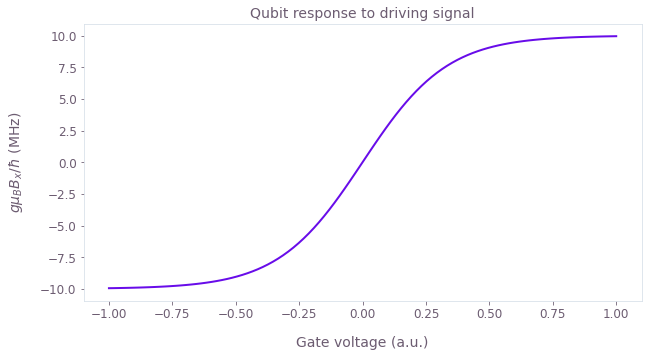

In [3]:
# Plot the response function.
voltage_range = np.linspace(-1, 1, 100)
qubit_response = response_function(voltage_range)

plt.plot(voltage_range, qubit_response / 2 / np.pi * 1e-6)
plt.ylabel("$g \mu_B B_x / \hbar$ (MHz)")
plt.xlabel("Gate voltage (a.u.)")
plt.title("Qubit response to driving signal");

This phenomenological response function represents well the experimental results of Undseth et al., as we will show by reproducing the Rabi oscillations. In an actual setup, this function should be measured for each quantum dot individually by driving only a single qubit and sweeping amplitude and offset of the signal. If the non-linearity is found to be unstable or difficult to measure accurately, then a variation to the non-linearity could also be added as a noise parameter in the simulation. This would allow us to find pulses that are robust towards errors in the calibration of the non-linearity. For the sake of simplicity, we use the same response function for all simulated qubits.

Next, we demonstrate how to validate a phenomenological model by reproducing the experimental results of Undseth et.al.. This requires only two control signals with a constant envelope. In the multiplexer, the constant signals $B_x{q_1}$ and $B_x{q_2}$ are modulated with the driving frequencies and added so that the total field is

$$B_x(t) = e^{-i \omega_{q_1} t} B_x{q_1} + e^{-i \omega_{q_2} t} B_x{q_2}.$$

In [4]:
control_segment_count = 100
time_step = 5e-9  # 5 ns
detuning = 2 * np.pi * 20e6  # 20 MHz
resonance_frequency = 2 * np.pi * 10e9  # 10 Ghz
time_sample_count = 1000

lab_frame_time_step = 2 * np.pi / resonance_frequency / 10
duration = control_segment_count * time_step
simulation_segment_count = int(np.round(duration / lab_frame_time_step))

Finally we define a function that creates a graph that implements our qubit model:

In [5]:
def simulate_single_qubit_with_offresonant_drive(
    graph, total_signal, resonance_frequency, time_sample_count=time_sample_count
):
    """
    Implement a Loss–Divincenzo qubit subjected to EDSR.
    """
    drift_hamiltonian = resonance_frequency * graph.pauli_matrix("Z") / 2

    control_hamiltonian = total_signal * 0.5 * graph.pauli_matrix("X")

    total_hamiltonian = drift_hamiltonian + control_hamiltonian

    initial_state = np.asarray([[1], [0]])

    time_array = np.linspace(0, duration, time_sample_count, endpoint=False)
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=total_hamiltonian, sample_times=time_array
    )

    propagated_states = unitaries @ initial_state
    propagated_states.name = "propagated_states"

We add a convenience function to execute the simulation.

In [6]:
def sweep_amplitudes_1q_sin(
    amps_q1,
    amps_q2,
    angular_freq_q1_drive=resonance_frequency,
    angular_freq_q2_drive=resonance_frequency + detuning,
    resonance_frequency_sim=resonance_frequency,
):
    graph = bo.Graph()

    # To efficiently simulate many experimental runs simultaneously,
    # we use the batching capabilities of Boulder Opal.
    q1_amplitude_batch = graph.constant_pwc(
        constant=amps_q1[:, None], duration=duration, batch_dimension_count=2
    )
    q2_amplitude_batch = graph.constant_pwc(
        constant=amps_q2[None, :], duration=duration, batch_dimension_count=2
    )

    # Modulate the driving signal.
    time_pwc = graph.discretize_stf(
        graph.identity_stf(), duration=duration, segment_count=simulation_segment_count
    )
    total_signal = graph.real(
        graph.exp(-1j * angular_freq_q1_drive * time_pwc) * q1_amplitude_batch
        + graph.exp(-1j * angular_freq_q2_drive * time_pwc) * q2_amplitude_batch
    )
    total_signal = response_function(graph=graph, voltage=total_signal)

    simulate_single_qubit_with_offresonant_drive(
        graph=graph,
        total_signal=total_signal,
        resonance_frequency=resonance_frequency_sim,
    )

    return bo.execute_graph(graph=graph, output_node_names="propagated_states")

Now that we have the simulation function defined, we consider a Rabi experiment where only one qubit (Q1) is driven and we plot the spin up probability of qubit Q1 as a function of time for various values of the driving field.

In [7]:
amps_q1_non_linearity = np.linspace(0.0, 1.0, 50, endpoint=True)
amps_q2_non_linearity = np.asarray([0])
result_sim_non_linearity = sweep_amplitudes_1q_sin(
    amps_q1=amps_q1_non_linearity, amps_q2=amps_q2_non_linearity
)
time_steps_ns = np.linspace(0, duration, time_sample_count, endpoint=False) * 1e9

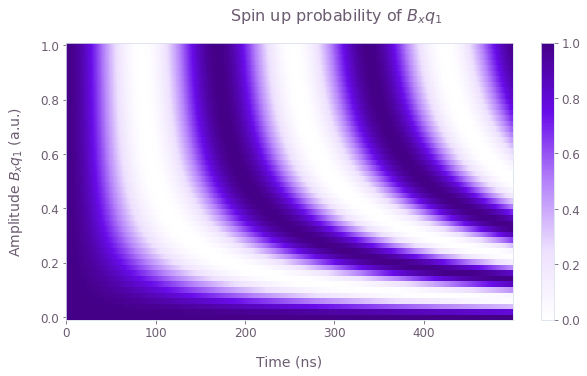

In [8]:
def plot_time_resolved(fig, ax, yy, zz, xx=time_steps_ns, qubit_str="Q1"):
    """
    Plot the time resolved spin population.
    """
    im = ax.pcolor(
        xx, yy, zz, shading="nearest", cmap=qv.QCTRL_SEQUENTIAL_COLORMAP, vmin=0, vmax=1
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel(f"Amplitude {qubit_str} (a.u.)")
    fig.suptitle(f"Spin up probability of {qubit_str}")
    fig.colorbar(im)


states = result_sim_non_linearity["output"]["propagated_states"]["value"][:, 0, :, 0, 0]
fig, ax = plt.subplots()
plot_time_resolved(
    fig=fig,
    ax=ax,
    yy=amps_q1_non_linearity,
    zz=np.abs(states) ** 2,
    qubit_str="$B_x{q_1}$",
);

In the plot above, the oscillation patterns for the different values of the voltage show that the effective Rabi rate initially rises (linearly) with the driving field before becoming constant in the strongly non-linear region.

Next, we want to investigate the influence of the crosstalk model by driving both qubits simultaneously. In this case we drive Q1 with a constant amplitude, ramp up the amplitude of the drive on qubit Q2, and then fit the resulting data to extract the effective Rabi-frequency.

In [9]:
amps_q1_simultaneous_drive = np.asarray([0.4])
amps_q2_simultaneous_drive = np.linspace(0.0, 0.8, 50, endpoint=True)
result_sim_simultaneous_drive = sweep_amplitudes_1q_sin(
    amps_q1=amps_q1_simultaneous_drive, amps_q2=amps_q2_simultaneous_drive
)

result_sim_q2_simultaneous_drive = sweep_amplitudes_1q_sin(
    amps_q1=amps_q1_simultaneous_drive,
    amps_q2=amps_q2_simultaneous_drive,
    resonance_frequency_sim=resonance_frequency + detuning,
)

In [10]:
def rabi_fit_func(t, rabi_freq):
    """
    Fit function to extract Rabi frequency.
    """
    return (np.cos(2 * np.pi * rabi_freq * t) + 1) / 2


time_array = np.linspace(0, duration, time_sample_count, endpoint=False)

# Fit the simulated data for qubit 1.
states = result_sim_simultaneous_drive["output"]["propagated_states"]["value"]
n_vals = states.shape[1]

rabi_freqs_q1 = np.zeros(shape=(n_vals,))

initial_vals_rabi_freq_q1 = np.linspace(10e6, 5e6, n_vals) / 2

for i in range(n_vals):
    popt, pcov = scipy.optimize.curve_fit(
        f=rabi_fit_func,
        xdata=time_array,
        ydata=np.abs(states[0, i, :, 0, 0]) ** 2,
        p0=initial_vals_rabi_freq_q1[i],
    )
    rabi_freqs_q1[i] = popt[0]

In [11]:
# Fit the simulated data for qubit 2.
rabi_freqs_q2 = np.zeros(shape=(n_vals,))

initial_vals_rabi_freq_q2 = np.linspace(0, 12e6, n_vals) / 2

states = result_sim_q2_simultaneous_drive["output"]["propagated_states"]["value"]
n_func_vals = states.shape[2]

for i in range(n_vals):
    if i < 10:
        n_fit_vals = n_func_vals
    else:
        n_fit_vals = 20000

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, pcov = scipy.optimize.curve_fit(
            f=rabi_fit_func,
            xdata=time_array[:n_fit_vals],
            ydata=np.abs(states[0, i, :n_fit_vals, 0, 0]) ** 2,
            p0=initial_vals_rabi_freq_q2[i],
            maxfev=4000,
            full_output=False,
        )
    rabi_freqs_q2[i] = popt[0]

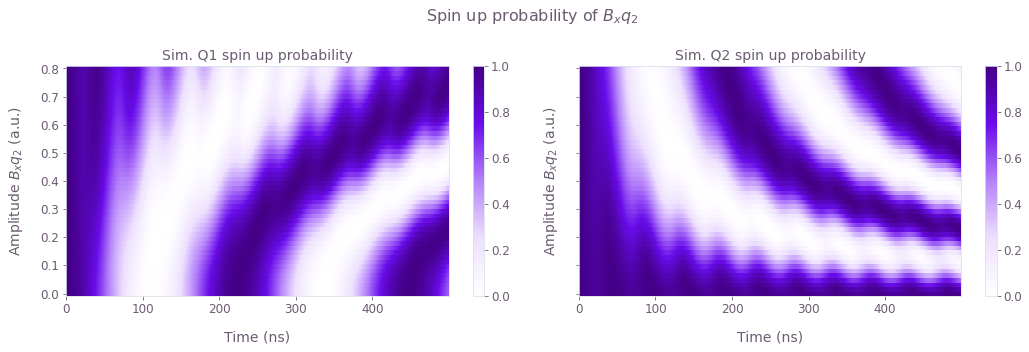

In [12]:
# Plot the simulation and fitted data.
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))

for ax_, zz_ in zip(
    ax, [result_sim_simultaneous_drive, result_sim_q2_simultaneous_drive]
):
    plot_time_resolved(
        fig=fig,
        ax=ax_,
        yy=amps_q2_simultaneous_drive,
        zz=np.abs(zz_["output"]["propagated_states"]["value"][0, :, :, 0, 0]) ** 2,
        qubit_str="$B_x{q_2}$",
    )

ax[0].set_title("Sim. Q1 spin up probability")
ax[1].set_title("Sim. Q2 spin up probability")
fig.tight_layout()

The simulated data resembles sufficiently closely the published data (compare Fig. 3, 4, and 5 in [Undseth et.al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.044078)), such that we can proceed with this model.

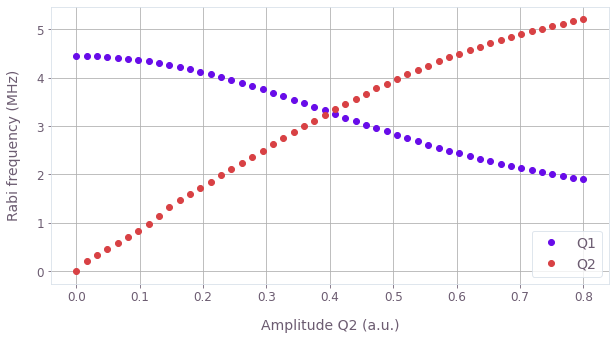

In [13]:
fig, ax = plt.subplots()
ax.plot(amps_q2_simultaneous_drive, rabi_freqs_q1 * 1e-6, "o", label="Q1")
ax.plot(amps_q2_simultaneous_drive, rabi_freqs_q2 * 1e-6, "o", label="Q2")
ax.set_xlabel(r"Amplitude Q2 (a.u.)")
ax.set_ylabel("Rabi frequency (MHz)")
ax.legend()
ax.grid();

We can clearly observe the strong influence of crosstalk. The effective Rabi frequency on qubit Q1 is reduced when increasing the amplitude of the drive on Q2. The Rabi frequency of qubit Q2 does not rise linearly with the increased amplitude.


## Mitigation of crosstalk

Based on the model above, we want to apply quantum robust control techniques to mitigate the crosstalk effect in 6-qubit arrays. The optimization is highly efficient, because we can neglect entanglement effects completely, as was demonstrated by [Undseth et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.044078) and the Hilbert space dimension thus scales only linearly with the number of simulated qubits. 

To mitigate the crosstalk, we will optimize the values of the piecewise constant envelopes of the effective resonant driving fields $B_x(t)$ on the different qubits. To simplify the problem and reduce the number of optimization variables, we will consider envelopes consisting of only two distinct time segments. In this case, we only need to optimize 2 complex degrees of freedom per qubit. For the implementation of the optimization, we proceed similarly to the simulation above.

In [14]:
def multiplexing_and_physical_response(
    graph, signals, angular_frequencies, simulation_segment_count, duration
):
    """
    Create the total drive signal.

    For correct batching, the signals must all have the same duration
    and the number of signals must match the number of angular_frequencies.
    """
    time_pwc = graph.discretize_stf(
        graph.identity_stf(), duration=duration, segment_count=simulation_segment_count
    )
    total_signal = 0
    for angular_frequency, signal in zip(angular_frequencies, signals):
        total_signal += graph.cos(angular_frequency * time_pwc) * graph.real(signal)
        total_signal += graph.sin(angular_frequency * time_pwc) * graph.imag(signal)

    return response_function(graph=graph, voltage=total_signal)


def calculate_propagated_states(
    graph,
    duration,
    angular_resonance_frequencies,
    total_hamiltonian,
    drift_hamiltonian,
    sample_times,
):
    """
    Calculate the propagated states in the rotating frame.
    """

    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=total_hamiltonian, sample_times=sample_times
    )
    transformation_unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=drift_hamiltonian, sample_times=sample_times
    )

    transformation_unitaries_conjugated = graph.adjoint(transformation_unitaries)

    initial_state = np.array([[1], [0]])
    propagated_states_rot_frame = (
        transformation_unitaries_conjugated @ unitaries @ initial_state
    )
    propagated_states_rot_frame.name = "prop_states_rot_frame"

In [15]:
def dense_array_graph(
    angular_resonance_frequencies,
    angular_driving_requencies,
    duration,
    simulation_segment_count,
    control_segment_count,
    sample_times,
    target_gate=None,
):
    graph = bo.Graph()

    signals = [
        graph.complex_optimizable_pwc_signal(
            segment_count=control_segment_count, duration=duration, maximum=1
        )
        for _ in angular_driving_requencies
    ]
    total_signal = multiplexing_and_physical_response(
        graph=graph,
        signals=signals,
        angular_frequencies=angular_driving_requencies,
        simulation_segment_count=simulation_segment_count,
        duration=duration,
    )

    # Drift Hamiltonian.
    frequency_batch = graph.constant_pwc(
        angular_resonance_frequencies, duration=duration, batch_dimension_count=1
    )
    drift_hamiltonian = frequency_batch * graph.pauli_matrix("Z") / 2

    # Control Hamiltonian.
    control_hamiltonian = total_signal * 0.5 * graph.pauli_matrix("X")

    # Evolution.
    total_hamiltonian = drift_hamiltonian + control_hamiltonian
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=total_hamiltonian, sample_times=[duration]
    )

    # Rotating frame.
    transformation_unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=drift_hamiltonian, sample_times=[duration]
    )

    transformation_unitaries_conjugated = graph.adjoint(transformation_unitaries)

    unitaries_rot_frame = (
        transformation_unitaries_conjugated @ unitaries @ transformation_unitaries
    )

    # Infidelity.
    if target_gate is None:
        target_gate = graph.pauli_matrix("X")

    infidelities = graph.unitary_infidelity(unitaries_rot_frame, target_gate)

    cost = graph.sum(infidelities, name="cost")

    # State evolution for visualization.
    calculate_propagated_states(
        graph=graph,
        duration=duration,
        angular_resonance_frequencies=angular_resonance_frequencies,
        total_hamiltonian=total_hamiltonian,
        drift_hamiltonian=drift_hamiltonian,
        sample_times=sample_times,
    )

    return graph

We can now run the optimization using Boulder Opal.

In [16]:
# We assume an equal spacing between the resonance frequencies of the six qubits.
qubit_count = 6
resonance_frequencies = [
    resonance_frequency - i * detuning
    # Rather go below the 10Ghz, because they are used to calculate the time step.
    for i in range(qubit_count)
]
lab_frame_time_step = 2 * np.pi / resonance_frequency / 10

duration = 400e-9
control_segment_count = 2

graph = bo.Graph()
simulation_segment_count = int(np.round(duration / lab_frame_time_step))

graph = dense_array_graph(
    angular_driving_requencies=resonance_frequencies,
    angular_resonance_frequencies=resonance_frequencies,
    duration=duration,
    simulation_segment_count=simulation_segment_count,
    control_segment_count=control_segment_count,
    sample_times=np.linspace(0, duration, 100),
)
# By chosing the resonance frequencies exactly as the
# driving frequencies, we neglect detuning errors or
# shifts in the resonance frequency.
# These effects can be inserted by a different choice of
# parameters.

result = bo.run_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["prop_states_rot_frame"],
    max_iteration_count=50,
    optimization_count=4,
    cost_history_scope="ALL",
)
print(f"Final infidelity: {result['cost']:.2e}")

Final infidelity: 2.08e-05


The resulting low infidelity shows that we can successfully apply an $X_\pi$-gate simultaneously on all six qubit with our simple choice of control envelopes with only two segments. This indicates that the mitigation of crosstalk will most likely not require any additional degrees of freedom in realistic pulse optimization scenarios. The solution does not require complicated pulses that may be hard to implement or difficult to calibrate experimentally.
    
We can now visualize the evolution of the individual qubits on the Bloch sphere. As we requested an $X_\pi$-gate on each qubit, we expect a $\pi$ rotation when starting in the logical state $\ket{0}$.

In [17]:
states = result["output"]["prop_states_rot_frame"]["value"]

n_qubit = 0  # Choose the qubit number to visualize.
qv.display_bloch_sphere(states=states[n_qubit, :, :, 0])

<IPython.core.display.Javascript object>

For a compact representation, we can also plot the spin up probability of the qubits.

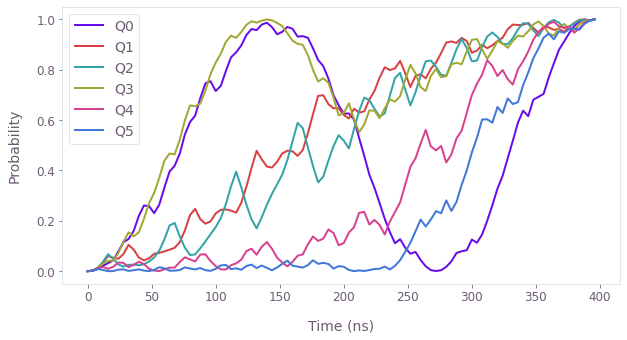

In [18]:
time_array = np.linspace(0, duration, 100, endpoint=False)
populations = {f"Q{i}": np.abs(states[i, :, 1, 0]) ** 2 for i in range(qubit_count)}
qv.plot_population_dynamics(sample_times=time_array, populations=populations)

In summary, we proposed a crosstalk model based on the nonlinear response of electrons in quantum dots to an electric driving signal. We demonstrated a resource efficient implementation in Boulder Opal and used quantum optimal control techniques to mitigate the crosstalk.

